In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('Groceries_dataset.csv')

In [3]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [4]:
df.shape

(38765, 3)

In [5]:
df.dtypes

Member_number       int64
Date               object
itemDescription    object
dtype: object

In [6]:
df.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [7]:
df.duplicated().sum()

759

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(38006, 3)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38006 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38006 non-null  int64 
 1   Date             38006 non-null  object
 2   itemDescription  38006 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [15]:
df['itemDescription'].value_counts()

itemDescription
whole milk               2363
other vegetables         1827
rolls/buns               1646
soda                     1453
yogurt                   1285
                         ... 
rubbing alcohol             5
bags                        4
baby cosmetics              3
kitchen utensil             1
preservation products       1
Name: count, Length: 167, dtype: int64

In [20]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

In [22]:
grouped = df.groupby(['Member_number','Date'])['itemDescription'].apply(list).reset_index()

In [23]:
trans = grouped['itemDescription'].tolist()

In [25]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit(trans).transform(trans)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [32]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True)
print(f"Itemsets found: {len(frequent_itemsets)}")

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print(f"Rules found: {len(rules)}")

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

Itemsets found: 750
Rules found: 130


,antecedents,consequents,support,confidence,lift
0,(UHT-milk),(other vegetables),0.002139,0.100000,0.818993
1,(UHT-milk),(whole milk),0.002540,0.118750,0.751949
2,(beef),(whole milk),0.004678,0.137795,0.872548
3,(berries),(other vegetables),0.002673,0.122699,1.004899
4,(berries),(whole milk),0.002272,0.104294,0.660414


In [38]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(df_encoded, min_support=0.001, use_colnames=True)
print(f"Itemsets found: {len(frequent_itemsets)}")
print(frequent_itemsets.sort_values(by='support', ascending=False).head())

Itemsets found: 750
     support            itemsets
0   0.157923        (whole milk)
17  0.122101  (other vegetables)
11  0.110005        (rolls/buns)
6   0.097106              (soda)
3   0.085879            (yogurt)


In [39]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print(f"Rules found: {len(rules)}")
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head()

Rules found: 130


,antecedents,consequents,support,confidence,lift
12,"(whole milk, yogurt)",(sausage),0.001470,0.131737,2.182917
11,"(sausage, whole milk)",(yogurt),0.001470,0.164179,1.911760
10,"(sausage, yogurt)",(whole milk),0.001470,0.255814,1.619866
70,(flour),(tropical fruit),0.001069,0.109589,1.617141
93,(processed cheese),(root vegetables),0.001069,0.105263,1.513019


In [40]:
top_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.2)]
top_rules = top_rules.sort_values(by='lift', ascending=False)
top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
10,"(sausage, yogurt)",(whole milk),0.001470,0.255814,1.619866
13,"(rolls/buns, sausage)",(whole milk),0.001136,0.212500,1.345594


(-0.5983439455594401,
 0.3246618218316757,
 -1.1398725078961107,
 0.47199163071621364)

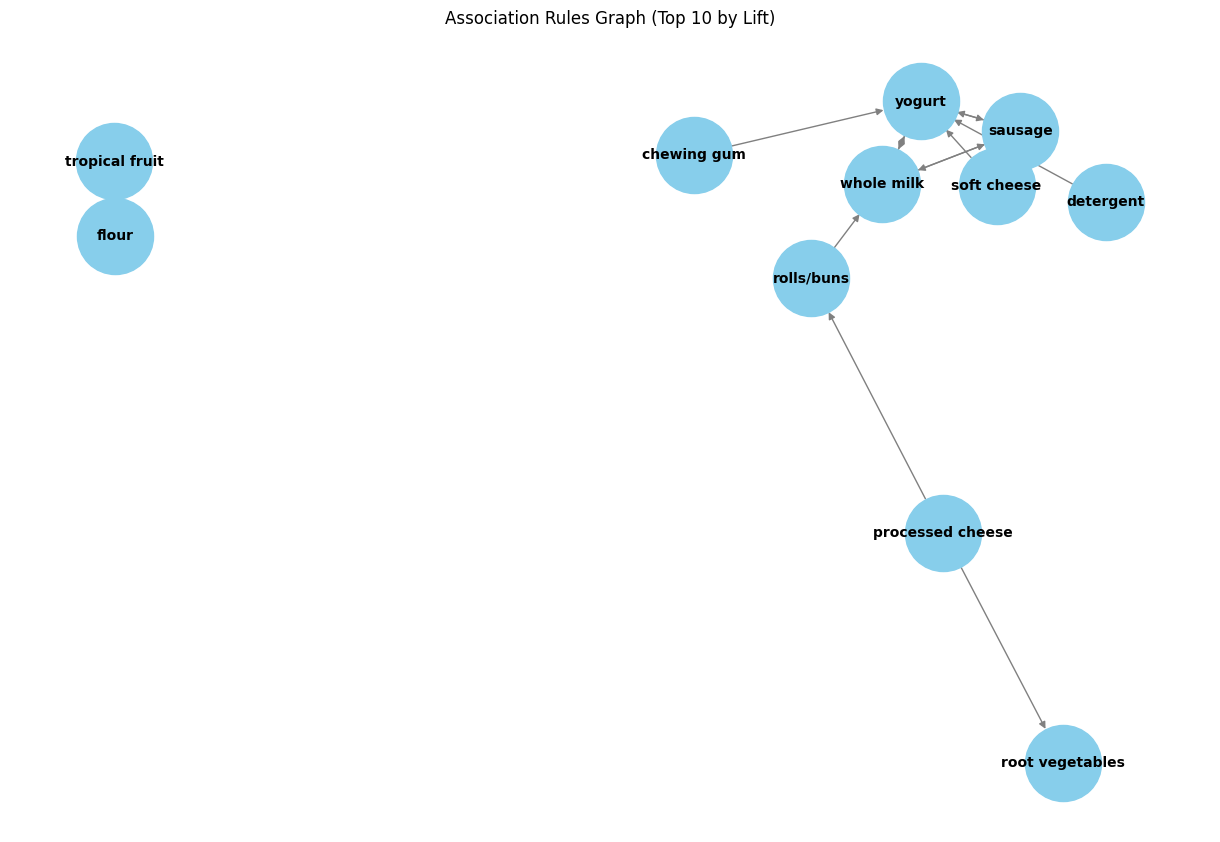

In [46]:
import networkx as nx

top_rules = rules.sort_values(by='lift', ascending=False).head(10)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            G.add_edge(ant, cons, weight=row['lift'], confidence=row['confidence'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)

nx.draw(G, pos,
        with_labels=True,
        node_size=3000,
        node_color='skyblue',
        font_size=10,
        font_weight='bold',
        arrows=True,
        edge_color='gray')

plt.title("Association Rules Graph (Top 10 by Lift)")
plt.axis('off')

In [47]:
rules.to_csv("association_rules.csv", index=False)
frequent_itemsets.to_csv("frequent_itemsets.csv", index=False)